In [61]:
import numpy as np
from scipy.stats import pearsonr
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

## Question 1

In [62]:
# Stocks parameters
d = 1
lbda = 1
sd = 0.01
mu = 0

# Other parameters
N = 10**4
S_0 = 100

## 1) 

In [63]:
# Compute stock prices
deg_free = np.array([3 , 10 , 50])
alpha = np.sqrt(deg_free / (deg_free - 2))/sd
names_col = ['t3' , 't10' , 't50' , 'norm']

# Compute the return simulations
df = pd.DataFrame(columns = names_col)
df.t3 = np.random.standard_t(3,N) / alpha[0]
df.t10 = np.random.standard_t(10,N) / alpha[1]
df.t50 = np.random.standard_t(50,N) / alpha[2]
df.norm = np.random.normal(mu,sd,N)


# Compute the loss function
L = pd.DataFrame(columns = names_col)
for i in range(4):
    L[names_col[i]] = - S_0 * (np.exp(df[names_col[i]]) - 1)

# Extract the loss means and std dev
sample_mean = L.mean()
sample_sd = L.std()
print('The mean of loss samples are: ')
print(sample_mean)
print('The standard deviation of loss samples are :')
print(sample_sd)


The mean of loss samples are: 
t3     -0.006980
t10    -0.002283
t50     0.004146
norm   -0.002723
dtype: float64
The standard deviation of loss samples are :
t3      0.949269
t10     1.003432
t50     0.997235
norm    0.994970
dtype: float64


For the generation of scaled student distribution of degree 3, Jarque Bera test leads to a p-value of : 0.0
At a 95% confidence level, we reject the normal distribution hypothesis
For the generation of scaled student distribution of degree 10, Jarque Bera test leads to a p-value of : 0.0
At a 95% confidence level, we reject the normal distribution hypothesis
For the generation of student distribution of degree 50, Jarque Bera test leads to a p-value of : 0.000395583365707
At a 95% confidence level, we reject the normal distribution hypothesis
For the generation of normal distribution, Jarque Bera test leads to a p-value of : 0.980724199479
At a 95% confidence level, we cannot reject the normal distribution hypothesis


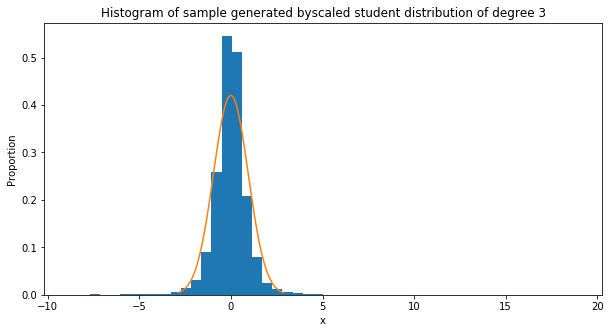

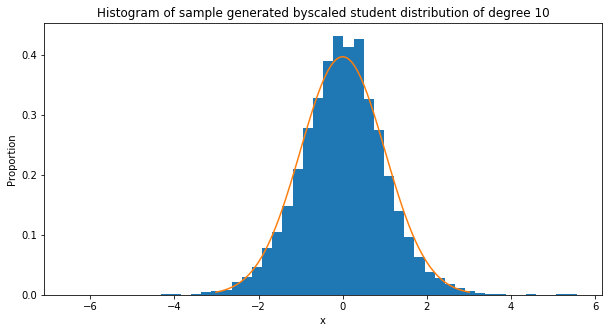

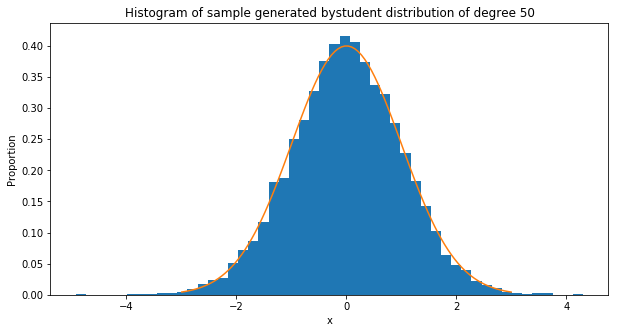

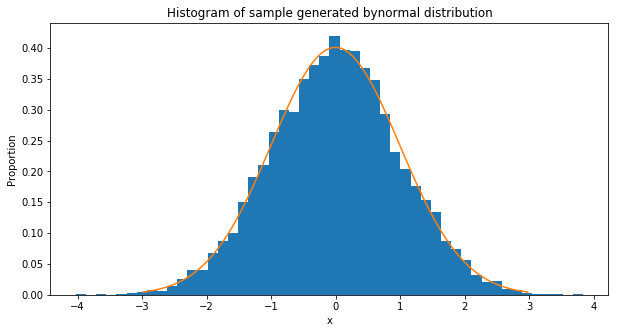

In [64]:
titles = ['scaled student distribution of degree 3','scaled student distribution of degree 10','student distribution of degree 50','normal distribution']
for i in range(4):
    plt.figure(figsize=(10,5))
    plt.hist(L[names_col[i]],bins = 50,normed = True)
    x = np.linspace(sample_mean[i] - 3*sample_sd[i], sample_mean[i] + 3*sample_sd[i], 100)
    plt.plot(x, stats.norm.pdf(x, sample_mean[i] , sample_sd[i]))
    plt.title('Histogram of sample generated by' + titles[i])
    plt.xlabel('x')
    plt.ylabel('Proportion')
    
for i in range(4):
    pval = stats.jarque_bera(L[names_col[i]])[1]
    print('For the generation of ' + titles[i] + ', Jarque Bera test leads to a p-value of : ' +   str(pval))
    if pval < 0.05:
        print('At a 95% confidence level, we reject the normal distribution hypothesis')
    else: 
        print('At a 95% confidence level, we cannot reject the normal distribution hypothesis')

## Question 2

In [65]:
#Model parameters
S = 100 
r = 0.05
sig = 0.2
T = 1
K = 100
delta = 1/252

In [66]:
# Compute X_1 X_2 X_3 
#df = pd.DataFrame(rnd @ upper_chol , columns = ['X_1' , 'X_2' , 'X_3'] )
cov = np.array([[10**-4, 0, -0.5 * 10**-5],[0, 10**-8, 0],[-0.5 * 10**-5, 0, 10**-6]])
df = pd.DataFrame(np.random.multivariate_normal([0,0,0],cov,10**4),columns = ['X_1' , 'X_2' , 'X_3'])
S_delta = S*np.exp(df.X_1)
r_delta = df.X_2 +r
sigma_delta = df.X_3 + sig

In [67]:
#Define black-scholes call
def call(S,K,q,r,sig,delta):
    d1 = (np.log(S/K) + (r - q + sig**2 /2) * delta) / (sig * np.sqrt(delta))
    d2 = d1 - sig * np.sqrt(delta)
    return np.exp(-q*delta)*S*stats.norm.cdf(d1) -np.exp(-r*delta)*K*stats.norm.cdf(d2)

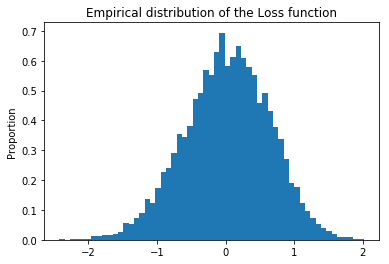

In [68]:
#Compute L
L = -(call(S_delta,K,0,r_delta,sigma_delta,T-delta)-call(S,K,0,r,sig,T))
plt.hist(L, density=True,bins = 'auto')
plt.title("Empirical distribution of the Loss function")
plt.ylabel('Proportion')
plt.show()

In [69]:
#Define the greeks
def Theta(S,K,q,r,sig,delta):
    d1 = (np.log(S/K) + (r - q + sig**2 /2) * delta) / (sig * np.sqrt(delta))
    d2 = d1 - sig * np.sqrt(delta)
    return - np.exp(- q * delta) * S * stats.norm.pdf(d1) * sig / ( 2 * np.sqrt(delta)) - r * K * np.exp(- r * delta) * stats.norm.cdf(d2) + q * S * np.exp(-q * delta) * stats.norm.cdf(d1)

def Delta(S,K,q,r,sig,delta):
    d1 = (np.log(S/K) + (r - q + sig**2 /2) * delta) / (sig * np.sqrt(delta))
    return np.exp(-q*delta) * stats.norm.cdf(d1)

def Rho(S,K,q,r,sig,delta):
    d1 = (np.log(S/K) + (r - q + sig**2 /2) * delta) / (sig * np.sqrt(delta))
    d2 = d1 - sig * np.sqrt(delta)
    return K * delta * np.exp(-r * delta) * stats.norm.cdf(d2)

def Vega(S,K,q,r,sig,delta):
    d1 = (np.log(S/K) + (r - q + sig**2 /2) * delta) / (sig * np.sqrt(delta))
    return S * np.exp(-q * delta) * stats.norm.pdf(d1) * np.sqrt(delta)




In [70]:
#Compute L_delta
L_t = - Theta(S,K,0,r,sig,T) * delta 
L_S = -  Delta(S,K,0,r,sig,T) * df.X_1 * S
L_r = - Rho(S,K,0,r,sig,T) * df.X_2
L_sig = - Vega(S,K,0,r,sig,T) * df.X_3
L_delta = L_t + L_S + L_r + L_sig
L_tot = [L_t , L_S , L_r , L_sig]
L_name = ['time' , 'stock price' , 'interest rate' , 'volatility']

In [71]:
for i in range(len(L_tot)):
    print('The first 2 moments of loss function due to change in ' + L_name[i] + ' are : mean = ' + str(round(L_tot[i].mean(),2)) + ' and stdev = ' + str(round(L_tot[i].std(),4)))

The first 2 moments of loss function due to change in time are : mean = 0.03 and stdev = 0.0
The first 2 moments of loss function due to change in stock price are : mean = 0.01 and stdev = 0.6365
The first 2 moments of loss function due to change in interest rate are : mean = 0.0 and stdev = 0.0054
The first 2 moments of loss function due to change in volatility are : mean = -0.0 and stdev = 0.0376


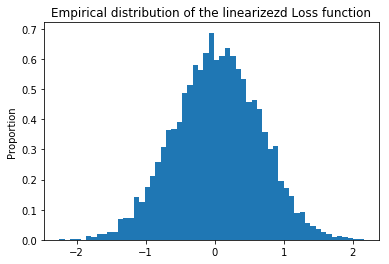

In [72]:
plt.hist(L_delta,density=True,bins = "auto")
plt.title("Empirical distribution of the linearizezd Loss function")
plt.ylabel('Proportion')
plt.show()